# Тренд во временных рядах. Коэффициент корреляции Кендалла.

## 1. Параметры исследования
- Уровень значимости `alpha`
- Число симуляций `N`
- Длина ряда `T`

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
np.random.seed(42)

alpha = 0.05  # уровень значимости
N = 1000      # число симуляций
T = 100       # длина временного ряда

## 2. Функции для моделирования и расчёта p-values

In [4]:
def simulate_noise(T):
    return np.random.normal(0, 1, size=T)

def simulate_season_noise(T, A=1, P=12):
    t = np.arange(T)
    season = A * np.sin(2 * np.pi * t / P)
    return season + np.random.normal(0, 1, size=T)

def simulate_trend_noise(T, b=0.05):
    t = np.arange(T)
    trend = b * t
    return trend + np.random.normal(0, 1, size=T)

def simulate_trend_season_noise(T, b=0.05, A=1, P=12):
    t = np.arange(T)
    trend = b * t
    season = A * np.sin(2 * np.pi * t / P)
    return trend + season + np.random.normal(0, 1, size=T)

def compute_pvalues(simulator, **kwargs):
    pvals = []
    for _ in range(N):
        series = simulator(T, **kwargs)
        _, p = kendalltau(np.arange(T), series)
        pvals.append(p)
    return np.array(pvals)

## 3. Оценка ошибки первого рода (сценарии без тренда, H₀)
### 3.1. «Чистый» шум
### 3.2. Сезонность + шум

Ошибка I рода (чистый шум):       0.050
Ошибка I рода (сезонность + шум): 0.016


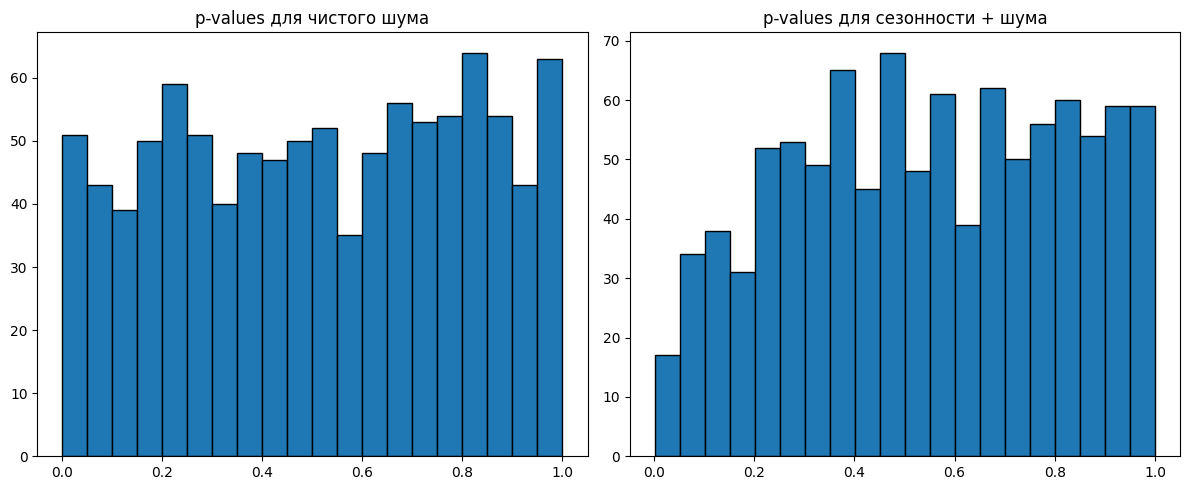

In [5]:
# Симуляция сценариев H0
p_noise  = compute_pvalues(simulate_noise)
p_season = compute_pvalues(simulate_season_noise)

# Расчёт доли ложных срабатываний
err_noise  = np.mean(p_noise  < alpha)
err_season = np.mean(p_season < alpha)

print(f"Ошибка I рода (чистый шум):       {err_noise:.3f}")
print(f"Ошибка I рода (сезонность + шум): {err_season:.3f}")

# Гистограммы p-value
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(p_noise,  bins=20, edgecolor='k')
plt.title('p-values для чистого шума')
plt.subplot(1,2,2)
plt.hist(p_season, bins=20, edgecolor='k')
plt.title('p-values для сезонности + шума')
plt.tight_layout()
plt.show()

## 4. Оценка мощности теста (сценарии с трендом, H₁)
### 4.1. Монотонный тренд + шум
### 4.2. Монотонный тренд + сезонность + шум

In [6]:
# Симуляция сценариев H1
p_trend        = compute_pvalues(simulate_trend_noise)
p_trend_season = compute_pvalues(simulate_trend_season_noise)

# Расчёт мощности
power_trend        = np.mean(p_trend        < alpha)
power_trend_season = np.mean(p_trend_season < alpha)

print(f"Мощность (тренд + шум):              {power_trend:.3f}")
print(f"Мощность (тренд + сезонность + шум): {power_trend_season:.3f}")

Мощность (тренд + шум):              1.000
Мощность (тренд + сезонность + шум): 1.000


## 5. Демонстрация на синтетическом «реальном» наборе данных

Здесь мы сгенерируем временной ряд с трендом и сезонностью, сохраним его в DataFrame и сразу проверим тестом Кендалла.

Kendall τ = 0.605, p-value = 0.000


C:\Users\dpro7\AppData\Local\Temp\ipykernel_25932\4280595755.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=T, freq='M')


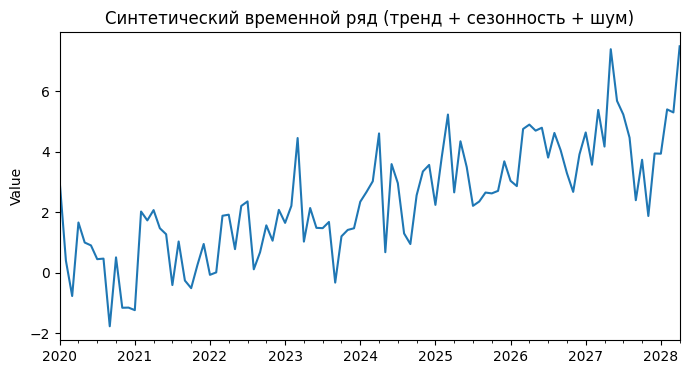

In [7]:
# 5.1 Генерация «реальных» данных
import pandas as pd

# создаём индекс дат (месячные наблюдения)
dates = pd.date_range(start='2020-01-01', periods=T, freq='M')

# генерируем значения: монотонный тренд + сезонность + шум
values = simulate_trend_season_noise(T, b=0.05, A=1, P=12)

# собираем в Series и DataFrame
series = pd.Series(values, index=dates, name='Value')
df_real = series.reset_index()
df_real.columns = ['Date', 'Value']

# (опционально) сохраняем в CSV
df_real.to_csv('synthetic_timeseries.csv', index=False)

# 5.2 Применение теста Кендалла
tau, p = kendalltau(np.arange(len(series)), series.values)
print(f"Kendall τ = {tau:.3f}, p-value = {p:.3f}")

# 5.3 Визуализация
plt.figure(figsize=(8,4))
series.plot(title='Синтетический временной ряд (тренд + сезонность + шум)')
plt.ylabel('Value')
plt.show()